In [1]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Create connection to database
database = "C:\\Users\\zubaz\\Documents\\Python\\EbayLegoWebscrape\\lego.db"
connection = sql.connect(database)

In [3]:
query1 = '''SELECT set_num, date, price
            FROM ebay_prices'''
query2 = '''SELECT * FROM set_details'''

In [4]:
df = pd.read_sql_query(query1, connection)
df.head()

,set_num,date,price
0,10256,02-01-2022,20.0
1,70147,01-07-2022,158.99
2,70222,01-07-2022,119.99
3,70223,01-07-2022,184.98
4,41052,01-07-2022,185.98


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55823 entries, 0 to 55822
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   set_num  55823 non-null  object
 1   date     55823 non-null  object
 2   price    55823 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


In [7]:
df_set = pd.read_sql_query(query2, connection)
df_set.head()

,set_num,set_name,theme_group,theme,subtheme,year_released,launch_exit,pieces,minifigs,designer,msrp,age_range,packaging,availability,rating
0,60009-1,Helicopter Arrest,Modern day,City,Police,2013,None,352.0,5,Henrik Andersen,£39.99 / $49.99,5 - 12,Box,Retail - limited,✭✭✭✭✩ 3.8 52 ratings
1,60012-1,Coast Guard 4x4 & Diving Boat,Modern day,City,Coast Guard,2013,01 Jun 2013 - 31 Jul 2015,128.0,2 (2 Unique to this set),None,£9.99 / $19.99 / 12.99€,5 - 12,Box,Retail,✭✭✭✭✩ 3.8 145 ratings 4 Reviews Official Brick...
2,75975-1,Watchpoint: Gibraltar,Licensed,Overwatch,None,2019,01 Jan 2019 - 31 Jul 2020,730.0,4 (3 Unique to this set),Mark Stafford,£79.99 / $89.99 / 87.72€,9+,Box,Retail,✭✭✭✭✩ 3.9 114 ratings 1 Review Official Bricks...
3,10155-1,Maersk Line Container Ship,Model making,Creator Expert,Maersk,2010,01 Aug 2010 - 31 Jul 2011,990.0,None,None,£102.99 / $119.99,8+,Box,LEGO exclusive,✭✭✭✭✩ 4.1 28 ratings 3 Reviews
4,10210-1,Imperial Flagship,Model making,Creator Expert,Miscellaneous,2010,01 Jan 2010 - 31 Dec 2011,1664.0,9 (6 Unique to this set),Raphael Pretesacque,£142.99 / $179.99,14+,Box,Retail - limited,✭✭✭✭✭ 4.6 171 ratings 16 Reviews


In [8]:
#change date column from text to datetime
df['date'] = pd.to_datetime(df['date'])

In [9]:
# find earliest and latest dates and how many days of data exists
oldest_date = df['date'].min()
recent_date = df['date'].max()
date_difference = recent_date - oldest_date
print(oldest_date)
print(recent_date)
print(date_difference)

2022-01-07 00:00:00
2022-02-07 00:00:00
31 days 00:00:00


In [10]:
# Check if all values in price column are intergers
all(x.is_integer() for x in df['price'])

False

In [11]:
print(df[pd.to_numeric(df['price'], errors='coerce').isnull()])

      set_num       date            price
26      75523 2022-01-19  25.79 to 135.81
38      10235 2022-02-06     3.29 to 4.98
41      10695 2022-01-21  16.37 to 122.89
95      21316 2022-01-11    9.89 to 13.89
108     70321 2022-02-02  20.25 to 282.98
...       ...        ...              ...
54653   75252 2022-01-07         1,095.95
55197   75827 2022-01-07         1,168.39
55487   10251 2022-01-22         1,286.32
55551   21137 2022-01-22         1,749.99
55710   10251 2022-02-06         1,081.17

[400 rows x 3 columns]


In [12]:
df.shape

(55823, 3)

In [13]:
# looks like the commas are bad, let's replace commas with nothing
df['price'] = df['price'].replace(',','', regex=True)


In [14]:
print(df['price'] [pd.to_numeric(df['price'], errors='coerce').isnull()])

26       25.79 to 135.81
38          3.29 to 4.98
41       16.37 to 122.89
95         9.89 to 13.89
108      20.25 to 282.98
2487     31.18 to 230.53
2792        2.29 to 2.59
9275     24.79 to 269.60
11800      2.26 to 13.58
14209     12.88 to 32.18
22574     27.10 to 60.98
28144     13.99 to 17.99
28806     20.00 to 76.00
40599     42.95 to 71.59
40603     19.99 to 79.99
42424    56.16 to 112.34
42435     6.71 to 100.75
43875     10.00 to 28.00
44008     20.90 to 24.90
44012     28.50 to 32.50
44014     25.80 to 29.80
44016     24.99 to 34.50
44042     25.99 to 29.99
44099     25.99 to 29.99
44100     24.50 to 28.50
44101     25.50 to 29.50
44102     25.99 to 29.99
44103     19.99 to 23.99
44104     25.99 to 29.99
44105     26.99 to 30.99
44106     22.99 to 26.99
44110     23.99 to 27.99
44111     24.99 to 28.99
44114     20.99 to 24.99
44115     22.50 to 26.50
44116     25.47 to 29.63
44117     27.36 to 31.47
44118     20.95 to 25.15
44119     24.19 to 28.40
44120     28.37 to 32.57


In [15]:
df.shape

(55823, 3)

In [16]:
# find the index of rows with 'to' in them
# these values are too hard to deal with, probably not representative listings
remove_rows = df[df['price'].str.contains("to") == True].index

print(remove_rows)


Int64Index([   26,    38,    41,    95,   108,  2487,  2792,  9275, 11800,
            14209, 22574, 28144, 28806, 40599, 40603, 42424, 42435, 43875,
            44008, 44012, 44014, 44016, 44042, 44099, 44100, 44101, 44102,
            44103, 44104, 44105, 44106, 44110, 44111, 44114, 44115, 44116,
            44117, 44118, 44119, 44120, 44121, 44122, 44124, 44153, 50551],
           dtype='int64')


In [17]:
# remove these rows
df.drop(remove_rows, inplace=True)

In [18]:
df.shape

(55778, 3)

In [19]:
print(df[pd.to_numeric(df['price'], errors='coerce').isnull()])

Empty DataFrame
Columns: [set_num, date, price]
Index: []


In [20]:
# checks price column to make sure all rows are numeric
pd.to_numeric(df['price'], errors='coerce').notnull().all()

True

In [21]:
df.dtypes

set_num            object
date       datetime64[ns]
price              object
dtype: object

In [22]:
# now that all rows in price column are numeric, change column data type to numeric
# pandas will pick int64 if there are no decimals, float 64 if decimals are present, which there are
df['price'] = pd.to_numeric(df['price'])
df.dtypes

set_num            object
date       datetime64[ns]
price             float64
dtype: object

In [23]:
# lets take a look at just the ghostbusters set data
filt = (df['set_num'] == 75827)
dffilt = df[filt].sort_values(by='price')
dffilt['price'].describe()


count      47.000000
mean      901.214043
std       259.450454
min         2.750000
25%       870.000000
50%       945.000000
75%       999.000000
max      1290.000000
Name: price, dtype: float64

<AxesSubplot:>

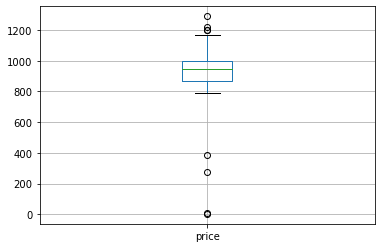

In [24]:
dffilt.boxplot(column=['price'])
# looks like we've got some outlier prices

In [25]:
# This is Tukey's rule, known as the IQR rule
# IQR = Inter Quartile Range
Q1 = dffilt['price'].quantile(0.25)
Q3 = dffilt['price'].quantile(0.75)
IQR = Q3 - Q1
IQR

129.0

In [26]:
# We will use 1.5*IQR for our limits, you can also use 2.5 or 2.0
lower_lim = Q1 - 1.5*IQR
upper_lim = Q3 + 1.5*IQR
lower_lim

676.5

In [27]:
upper_lim

1192.5

In [28]:
# how many rows below our low limit?
outliers_15_low = ( dffilt['price'] < lower_lim)
len(dffilt['price'][outliers_15_low])

4

In [29]:
# how many rows above high limit?
outliers_15_high = ( dffilt['price'] > upper_lim)
len(dffilt['price'][outliers_15_high])

4

In [30]:
# the tilda ~ reverses the filtered indexes
dffilt = dffilt[~(outliers_15_low | outliers_15_high)]


In [31]:
dffilt

,set_num,date,price
48714,75827,2022-01-07,789.99
53327,75827,2022-01-07,798.00
51259,75827,2022-01-18,799.00
19239,75827,2022-01-07,799.00
45737,75827,2022-01-26,800.00
48178,75827,2022-01-07,839.00
32310,75827,2022-01-14,844.64
50122,75827,2022-01-26,865.00
2035,75827,2022-01-22,875.00
33892,75827,2022-01-07,894.81


<AxesSubplot:>

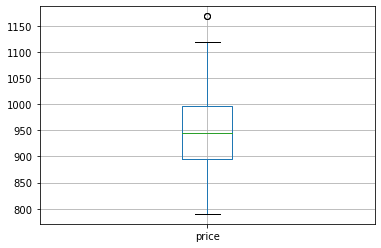

In [32]:
dffilt.boxplot(column='price')

In [ ]:
# Group the price data by date and calculate the mean
# i.e. create a new dataframe with one date per row and the average sales price
dffilt_group = dffilt.groupby(['date']).mean()
dffilt_group

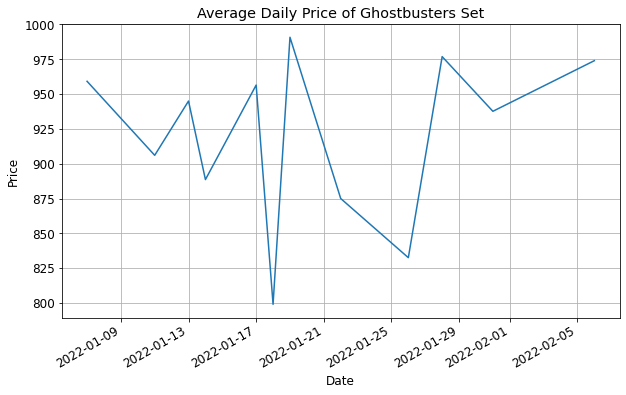

In [54]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(dffilt_group.index, dffilt_group.price, label='Average Daily Price')

fig.autofmt_xdate()
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Average Daily Price of Ghostbusters Set')
ax.grid(True);

In [35]:
# time to clean the set_details data
df_set.head()

,set_num,set_name,theme_group,theme,subtheme,year_released,launch_exit,pieces,minifigs,designer,msrp,age_range,packaging,availability,rating
0,60009-1,Helicopter Arrest,Modern day,City,Police,2013,None,352.0,5,Henrik Andersen,£39.99 / $49.99,5 - 12,Box,Retail - limited,✭✭✭✭✩ 3.8 52 ratings
1,60012-1,Coast Guard 4x4 & Diving Boat,Modern day,City,Coast Guard,2013,01 Jun 2013 - 31 Jul 2015,128.0,2 (2 Unique to this set),None,£9.99 / $19.99 / 12.99€,5 - 12,Box,Retail,✭✭✭✭✩ 3.8 145 ratings 4 Reviews Official Brick...
2,75975-1,Watchpoint: Gibraltar,Licensed,Overwatch,None,2019,01 Jan 2019 - 31 Jul 2020,730.0,4 (3 Unique to this set),Mark Stafford,£79.99 / $89.99 / 87.72€,9+,Box,Retail,✭✭✭✭✩ 3.9 114 ratings 1 Review Official Bricks...
3,10155-1,Maersk Line Container Ship,Model making,Creator Expert,Maersk,2010,01 Aug 2010 - 31 Jul 2011,990.0,None,None,£102.99 / $119.99,8+,Box,LEGO exclusive,✭✭✭✭✩ 4.1 28 ratings 3 Reviews
4,10210-1,Imperial Flagship,Model making,Creator Expert,Miscellaneous,2010,01 Jan 2010 - 31 Dec 2011,1664.0,9 (6 Unique to this set),Raphael Pretesacque,£142.99 / $179.99,14+,Box,Retail - limited,✭✭✭✭✭ 4.6 171 ratings 16 Reviews


In [36]:
# remove -1 from set_num
df_set['set_num'] = df_set['set_num'].str.split('-', n=1).str[0]

In [37]:
# split launch_exit column into 2 columns
df_set[['launch_date', 'retirement_date']] = df_set['launch_exit'].str.split(' - ', expand=True)

In [38]:
df_set.drop('launch_exit', axis=1, inplace=True)

In [39]:
# need to plit the minifigs column into total and unique
df_set[['minifigs_total', 'minifigs_unique']] = df_set['minifigs'].str.split(' ', n=1, expand=True)

In [40]:
# parse the minifig value from minifigs_unique
df_set['minifigs_unique'] = df_set['minifigs_unique'].str.split(' ', n=1).str[0].str.replace('(', '', regex=True)

In [41]:
df_set.drop('minifigs', axis=1, inplace=True)

In [42]:
# parse rating column to get the text after the stars, this grabs non numeric values for rows with no rating
df_set['rating'] = df_set['rating'].str.split(' ', n=2).str[1].str.strip()

In [43]:
# a good way to replace non-numeric rows is to_numeric method, must use coerce to force NaN values for non-numerics
df_set['rating'] = pd.to_numeric(df_set['rating'], errors='coerce')

In [44]:
# change launch retirement date columns to date
# first need to remove spaces
df_set['launch_date'] = df_set['launch_date'].str.replace(' ', '')
df_set['launch_date'] = pd.to_datetime(df_set['launch_date'], format='%d%b%Y', errors='coerce')

In [45]:
# had some t.b.a text for some rows, they threw an error, added errors=coerce and seemed to fix it
df_set['retirement_date'] = df_set['retirement_date'].str.replace(' ', '')
df_set['retirement_date'] = pd.to_datetime(df_set['retirement_date'], format='%d%b%Y', errors='coerce')

In [46]:
# clean up msrp column and grab USD values only - drop pounds and euro values if present
# use regex to extract everything after the $, the dot, and the remaining digits
# REGEX sucks. But remember to use regex101.com, it's a life saver
df_set['msrp'] = df_set['msrp'].str.extract(r"\$(\d+\.\d+)")

In [47]:
# if launch_date is empty add the value from year released date column, 
df_set['launch_date'] = df_set['launch_date'].fillna(df_set['year_released'])
# very cool, it added jan 1 to the year automatically.

In [48]:
df_set['year_released'] = df_set['year_released'].astype(int)

In [49]:
df_set['msrp'] = df_set['msrp'].astype(float)

In [50]:
df_set['minifigs_total'] = df_set['minifigs_total'].astype(float)
df_set['minifigs_unique'] = df_set['minifigs_unique'].astype(float)

In [51]:
df_set.dtypes

set_num                    object
set_name                   object
theme_group                object
theme                      object
subtheme                   object
year_released               int32
pieces                    float64
designer                   object
msrp                      float64
age_range                  object
packaging                  object
availability               object
rating                    float64
launch_date        datetime64[ns]
retirement_date    datetime64[ns]
minifigs_total            float64
minifigs_unique           float64
dtype: object